Pacakge Import

In [90]:
import pandas as pd
import time
from datetime import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np


Alpha vantage API Sample

In [146]:
# #api reference: https://www.alphavantage.co/documentation/
# api_key = '5E306MLI09NMQC7G'

# import requests

# # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TQQQ&interval=60min&month=2024-1&outputsize=full&apikey={api_key}'
# r = requests.get(url)
# data = r.json()

# print(data)


# df = pd.DataFrame()

# year = [2017+i for i in range(8)]
# month = [i+1 for i in range(12)]

# sleep_schedule = 0

# for y in year:
#     for m in month:
#         retrieval_date = str(y) + "-" + str(m)

#         url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TQQQ&interval=60min&month={retrieval_date}&outputsize=full&apikey={api_key}'
#         r = requests.get(url)
#         data = r.json()

#         print(retrieval_date)
#         dates = [d for d in data['Time Series (60min)'].keys()]
#         close = [data['Time Series (60min)'][date]['4. close'] for date in dates]

#         df = pd.concat([df, pd.DataFrame({'date': dates, 'price': close})])
#         sleep_schedule += 1

#         if sleep_schedule % 5 == 0:
#             time.sleep(60)

Polygon IO Data Collection

In [1]:
start_date = '2024-01-24'
url = f'https://api.polygon.io/v2/aggs/ticker/TQQQ/range/1/day/2017-01-01/{start_date}?adjusted=true&sort=asc&limit=50000&apiKey=RMnfdtr9nmyTjXjgbNJeX_I5pIcowZpl'
r = requests.get(url)
data = r.json()

close = []
high = []
low = []
time = []

while 'next_url' in data.keys():
    for d in data['results']:
        close.append(d['c'])
        high.append(d['h'])
        low.append(d['l'])
        time.append(datetime.fromtimestamp(int(str(d['t'])[:-3])))

    url = data['next_url']+"&apiKey=RMnfdtr9nmyTjXjgbNJeX_I5pIcowZpl"
    r = requests.get(url)
    data = r.json()

    print(f"Latest Time: {time[-1]}")

df = pd.DataFrame({'time': time, 'high': high, 'low': low, 'close': close})

NameError: name 'requests' is not defined

In [192]:
df

,time,high,low,close,close_mv_avg,diff_to_mv_avg,diff_to_mv_avg_pct,2pct_bool
0,2019-01-25 04:00:00,10.9725,10.8900,10.9025,NaN,NaN,NaN,0
1,2019-01-25 05:00:00,10.9750,10.9000,10.9600,NaN,NaN,NaN,0
2,2019-01-25 06:00:00,11.0050,10.9500,10.9650,NaN,NaN,NaN,0
3,2019-01-25 07:00:00,10.9725,10.9225,10.9625,NaN,NaN,NaN,0
4,2019-01-25 08:00:00,11.0875,10.9250,11.0600,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
19395,2023-11-20 07:00:00,43.3700,43.1200,43.1500,40.745936,2.404064,5.900131,0
19396,2023-11-20 08:00:00,43.4212,42.6800,43.3000,40.780249,2.519751,6.178852,0
19397,2023-11-20 09:00:00,43.9677,43.1200,43.9598,40.818117,3.141683,7.696786,0
19398,2023-11-20 10:00:00,44.0100,43.4900,43.9850,40.855836,3.129164,7.659039,0


Data Manipulation

In [121]:
#Getting Moving Average of 160 hours = 10 days
df['close_mv_avg'] = df.close.rolling(16*10).mean()
#Calculating the Different of the current closing price to the moving average
df['diff_to_mv_avg'] = df['close'] - df['close_mv_avg']
#calculating the percent difference of the current closing price to the moving average
df['diff_to_mv_avg_pct'] = df['diff_to_mv_avg']*100/df['close_mv_avg']
#boolean whether the percentage drop from moving average to current price is less than or equal to -3%
df['2pct_bool'] = [1 if row[1]['diff_to_mv_avg_pct'] <= -3 else 0 for row in  df.iterrows()]

In [159]:
print(f'Proportion of cases where there is more than 3% drop in current closing price compared to 160 hour moving average:')
print(round(df[df['2pct_bool'] == 1].shape[0]/df.shape[0],2))

Proportion of cases where there is more than 3% drop in current closing price compared to 160 hour moving average:
0.26


In [122]:
#only looking for data points that has moving average values available
df2 = df.dropna().reset_index(drop = True)

In [175]:
# pct = for each hour of examination, calculating the percentage difference to 80 hours moving forward (10 days) and each observation would contain 80 percentages in a list
# t_total = proportion of hours out of 80 hours where the price of TQQQ has gone up by more than 2%
pct = []
t_total = []
t = 0

for row in df2.iterrows():
    try:
        pct_temp = []
        for i in range(10*16):
            pct_temp.append((row[1]['close'] - df2.loc[row[0]+i,'close'])/row[1]['close'])
            if pct_temp[-1] <= -0.02:
                t+=1
        t_total.append(t/(10*16))
        pct.append(pct_temp)
        t = 0
    except(ValueError, KeyError):
        t_total.append(np.nan)
        pct.append(np.nan)

df2['daily_diff_pct'] = pct
df2['daily_above_2pct'] = t_total

5 min interval 9:30AM - 4:00PM

In [186]:
df.head(16)

,time,high,low,close,close_mv_avg,diff_to_mv_avg,diff_to_mv_avg_pct,2pct_bool
0,2019-01-25 04:00:00,10.9725,10.8900,10.9025,NaN,NaN,NaN,0
1,2019-01-25 05:00:00,10.9750,10.9000,10.9600,NaN,NaN,NaN,0
2,2019-01-25 06:00:00,11.0050,10.9500,10.9650,NaN,NaN,NaN,0
3,2019-01-25 07:00:00,10.9725,10.9225,10.9625,NaN,NaN,NaN,0
4,2019-01-25 08:00:00,11.0875,10.9250,11.0600,NaN,NaN,NaN,0
5,2019-01-25 09:00:00,11.1025,10.9550,11.0952,NaN,NaN,NaN,0
6,2019-01-25 10:00:00,11.2025,11.0900,11.1800,NaN,NaN,NaN,0
7,2019-01-25 11:00:00,11.2550,11.1350,11.2500,NaN,NaN,NaN,0
8,2019-01-25 12:00:00,11.2925,11.1550,11.2175,NaN,NaN,NaN,0
9,2019-01-25 13:00:00,11.2650,11.1775,11.2525,NaN,NaN,NaN,0


Analysis

Distribution of Percentage Drop from the Moving Average

(array([  29.,   53.,  118.,  417., 1997., 4378., 8564., 3250.,  395.,
          40.]),
 array([-44.70155424, -37.35128294, -30.00101164, -22.65074034,
        -15.30046904,  -7.95019774,  -0.59992643,   6.75034487,
         14.10061617,  21.45088747,  28.80115877]),
 <BarContainer object of 10 artists>)

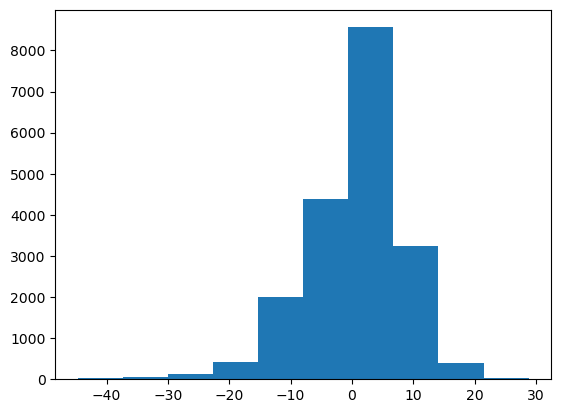

In [176]:
plt.hist(df2['diff_to_mv_avg_pct'])

Distribution of 'daily_above_2pct'(proportion of hours out of 80 hours since the day of analysis where the price has gone up more than 2%) for the hours where the price has dropped more than 3% from the 160 hour moving average <br>
--> 

(array([1464.,  491.,  485.,  329.,  302.,  270.,  280.,  310.,  477.,
         710.]),
 array([0.      , 0.099375, 0.19875 , 0.298125, 0.3975  , 0.496875,
        0.59625 , 0.695625, 0.795   , 0.894375, 0.99375 ]),
 <BarContainer object of 10 artists>)

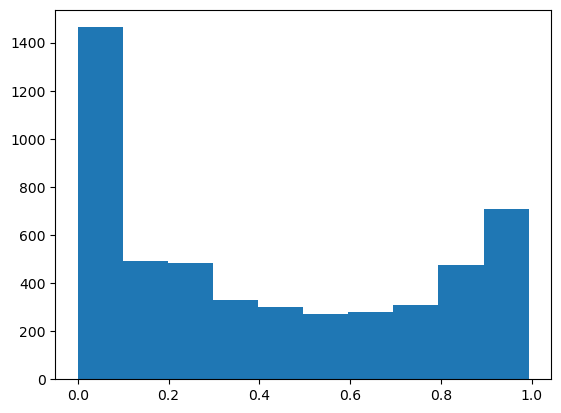

In [177]:
ttt = df2[df2['2pct_bool'] == 1].reset_index(drop = True)
plt.hist(ttt['daily_above_2pct'])

In [188]:
1 - 1464/np.sum([1464.,  491.,  485.,  329.,  302.,  270.,  280.,  310.,  477.,710.])

0.7139507620164127

In [167]:
df2['year'] = [t.year for t in df2['time']]
df2['month'] = [t.month for t in df2['time']]
df2['q'] = [1 if t in [1,2,3] else 2 if t in [4,5,6] else 3 if t in [7,8,9] else 4 for t in df2['month']]

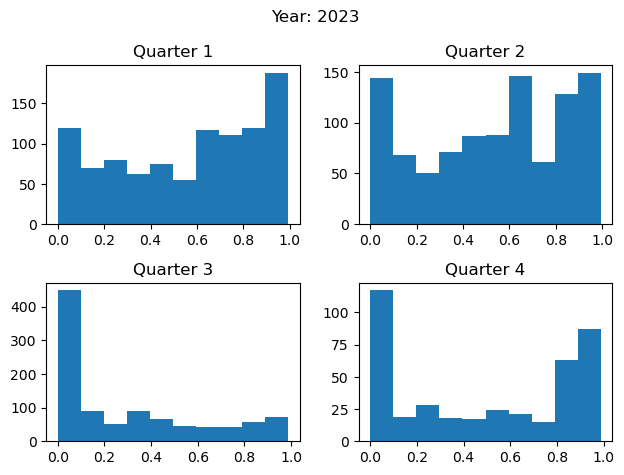

In [191]:
year = 2023
tttt = df2[df2['year'] == year]

fig, axs = plt.subplots(2, 2)

axs[0,0].hist(tttt[tttt['q'] == 1]['daily_above_2pct'])
axs[0,0].set_title('Quarter 1')
axs[0,1].hist(tttt[tttt['q'] == 2]['daily_above_2pct'])
axs[0,1].set_title('Quarter 2')
axs[1,0].hist(tttt[tttt['q'] == 3]['daily_above_2pct'])
axs[1,0].set_title('Quarter 3')
axs[1,1].hist(tttt[tttt['q'] == 4]['daily_above_2pct'])
axs[1,1].set_title('Quarter 4')
fig.suptitle(f"Year: {year}")
fig.tight_layout()


(array([  29.,   53.,  118.,  417., 1997., 4378., 8564., 3250.,  395.,
          40.]),
 array([-44.70155424, -37.35128294, -30.00101164, -22.65074034,
        -15.30046904,  -7.95019774,  -0.59992643,   6.75034487,
         14.10061617,  21.45088747,  28.80115877]),
 <BarContainer object of 10 artists>)

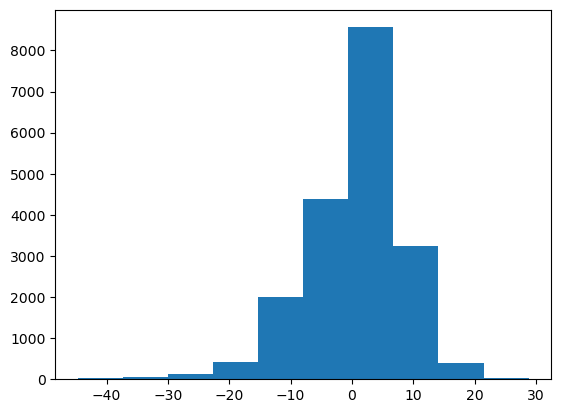

In [145]:
plt.hist(df2['diff_to_mv_avg_pct'])

In [184]:
df2.groupby(['year','q','2pct_bool'])['daily_above_2pct'].mean()

year  q  2pct_bool
2019  1  0            0.548037
         1            0.920052
      2  0            0.485975
         1            0.296123
      3  0            0.289218
         1            0.448438
      4  0            0.586968
         1            0.777923
2020  1  0            0.511785
         1            0.333772
      2  0            0.661520
         1            0.945703
      3  0            0.553680
         1            0.456088
      4  0            0.497390
         1            0.509357
2021  1  0            0.432273
         1            0.523309
      2  0            0.525851
         1            0.474581
      3  0            0.324570
         1            0.313174
      4  0            0.450349
         1            0.680934
2022  1  0            0.283526
         1            0.389543
      2  0            0.179334
         1            0.314098
      3  0            0.541197
         1            0.227589
      4  0            0.257155
         1          

In [129]:
(342+482+792)/len(df2[(df2['2pct_bool']==1)]['daily_above_2pct'])

0.31574833919499806

(array([6164., 1525., 1488., 1300., 1379., 1313., 1356., 1457., 1661.,
        1519.]),
 array([0.     , 0.09875, 0.1975 , 0.29625, 0.395  , 0.49375, 0.5925 ,
        0.69125, 0.79   , 0.88875, 0.9875 ]),
 <BarContainer object of 10 artists>)

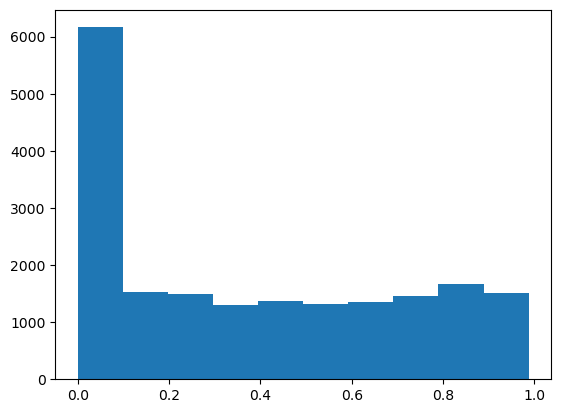

In [143]:
plt.hist(df2['daily_above_2pct'])

In [142]:
df2[df2['daily_above_2pct'] >= 0.5].groupby(['2pct_bool']).count()

,time,high,low,close,close_mv_avg,diff_to_mv_avg,diff_to_mv_avg_pct,daily_diff_pct,daily_above_2pct
2pct_bool,,,,,,,,,
0,5392,5392,5392,5392,5392,5392,5392,5392,5392
1,1914,1914,1914,1914,1914,1914,1914,1914,1914


In [135]:
len(df2.daily_diff_pct[0])

192

In [136]:
12*16

192

In [54]:
from prophet import Prophet


In [55]:
p_df = df2[['time','close']]

In [58]:
p_df.columns = ['ds','y']

In [60]:
p_df.shape[0]*.7

13468.699999999999

In [64]:
train = p_df.iloc[:13468,:].reset_index(drop = True)
test = p_df.iloc[13468:,:].reset_index(drop = True)

In [68]:
m = Prophet()
m.fit(train)

05:22:05 - cmdstanpy - INFO - Chain [1] start processing
05:22:27 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
future = m.make_future_dataframe(periods=test.shape[0], freq = 'H')


In [71]:
forecast = m.predict(future)

In [76]:
forecast.loc[13468:,'yhat']

13468    28.472700
13469    28.458064
13470    28.442376
13471    28.437150
13472    28.442199
           ...    
19236    15.417464
19237    15.416397
19238    15.397282
19239    15.326889
19240    15.198995
Name: yhat, Length: 5773, dtype: float64

In [74]:
from sklearn.metrics import mean_absolute_percentage_error

In [77]:
mean_absolute_percentage_error(test.y,forecast.loc[13468:,'yhat'] )

0.18896997628847378

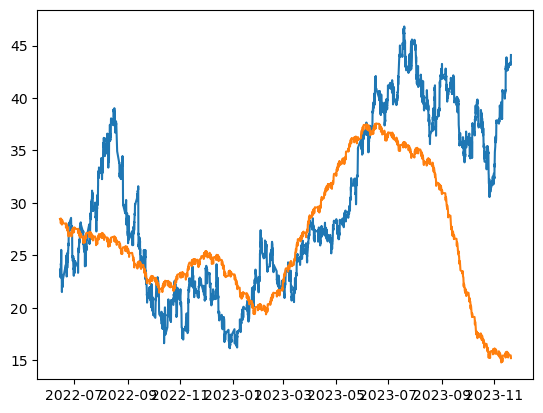

In [86]:
plt.plot(test.ds,test.y)
plt.plot(test.ds,forecast.loc[13468:,'yhat'])
# plt.fill_between(test.ds, forecast.loc[13468:,'yhat_lower'], forecast.loc[13468:,'yhat_upper'], color='r', alpha=.15)

In [83]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-07 19:00:00,8.560701,10.180905,18.087843,8.560701,8.560701,5.666300,5.666300,5.666300,0.057529,...,0.143481,0.143481,0.143481,5.465290,5.465290,5.465290,0.0,0.0,0.0,14.227001
1,2019-02-08 04:00:00,8.617300,10.421013,17.982989,8.617300,8.617300,5.706571,5.706571,5.706571,0.122601,...,0.104641,0.104641,0.104641,5.479329,5.479329,5.479329,0.0,0.0,0.0,14.323871
2,2019-02-08 05:00:00,8.623589,10.617903,18.009570,8.623589,8.623589,5.706801,5.706801,5.706801,0.124626,...,0.101528,0.101528,0.101528,5.480648,5.480648,5.480648,0.0,0.0,0.0,14.330390
3,2019-02-08 06:00:00,8.629877,10.421682,18.273847,8.629877,8.629877,5.687794,5.687794,5.687794,0.107400,...,0.098476,0.098476,0.098476,5.481918,5.481918,5.481918,0.0,0.0,0.0,14.317671
4,2019-02-08 07:00:00,8.636166,10.374351,18.067264,8.636166,8.636166,5.675944,5.675944,5.675944,0.097386,...,0.095421,0.095421,0.095421,5.483137,5.483137,5.483137,0.0,0.0,0.0,14.312110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19236,2023-02-09 17:00:00,9.716075,-103.753343,133.952010,-107.867920,129.199948,5.701388,5.701388,5.701388,0.053330,...,0.155924,0.155924,0.155924,5.492135,5.492135,5.492135,0.0,0.0,0.0,15.417464
19237,2023-02-09 18:00:00,9.710902,-102.638836,134.734948,-107.914041,129.213598,5.705494,5.705494,5.705494,0.064605,...,0.149519,0.149519,0.149519,5.491369,5.491369,5.491369,0.0,0.0,0.0,15.416397
19238,2023-02-09 19:00:00,9.705729,-99.927022,135.325109,-107.938581,129.227247,5.691552,5.691552,5.691552,0.057529,...,0.143481,0.143481,0.143481,5.490542,5.490542,5.490542,0.0,0.0,0.0,15.397282
19239,2023-02-09 20:00:00,9.700557,-103.038930,134.782355,-107.946278,129.240896,5.626333,5.626333,5.626333,-0.001137,...,0.137819,0.137819,0.137819,5.489651,5.489651,5.489651,0.0,0.0,0.0,15.326889
